# CCC GPU Speedup Analysis

This notebook parses benchmark logs from the `scale_on_n_features` directory and generates speedup charts comparing GPU vs CPU performance.

In [95]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [96]:
# Configuration
SAVE_OUTPUTS = False  # Set to True to save plots and CSV files

## Parse Log Files

In [97]:
def parse_filename(filename):
    """
    Parse filename to extract seed, features, samples, and cores.
    Example: test_ccc_gpu_42_f500_n1000_c6.log
    Returns: (seed, features, samples, cores)
    """
    pattern = r'test_ccc_gpu_(\d+)_f(\d+)_n(\d+)_c(\d+)\.log'
    match = re.match(pattern, filename)
    if match:
        seed = int(match.group(1))
        features = int(match.group(2))
        samples = int(match.group(3))
        cores = int(match.group(4))
        return seed, features, samples, cores
    return None

def parse_log_content(filepath):
    """
    Parse log file content to extract GPU time, CPU time, and speedup.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    gpu_time_match = re.search(r'GPU time: ([\d.]+) seconds', content)
    cpu_time_match = re.search(r'CPU time: ([\d.]+) seconds', content)
    speedup_match = re.search(r'Speedup: ([\d.]+)x', content)
    
    if gpu_time_match and cpu_time_match and speedup_match:
        gpu_time = float(gpu_time_match.group(1))
        cpu_time = float(cpu_time_match.group(1))
        speedup = float(speedup_match.group(1))
        return gpu_time, cpu_time, speedup
    return None

def collect_benchmark_data(logs_dir):
    """
    Collect all benchmark data from log files.
    """
    data = []
    
    for filename in os.listdir(logs_dir):
        if not filename.endswith('.log'):
            continue
        
        # Parse filename
        parsed_filename = parse_filename(filename)
        if not parsed_filename:
            continue
        
        seed, features, samples, cores = parsed_filename
        
        # Parse log content
        filepath = os.path.join(logs_dir, filename)
        parsed_content = parse_log_content(filepath)
        if not parsed_content:
            continue
        
        gpu_time, cpu_time, speedup = parsed_content
        
        data.append({
            'seed': seed,
            'features': features,
            'samples': samples,
            'cores': cores,
            'gpu_time': gpu_time,
            'cpu_time': cpu_time,
            'speedup': speedup,
            'filename': filename
        })
    
    return pd.DataFrame(data)

In [98]:
# Set the logs directory path
logs_dir = 'analysis/03-manuscript/90_benchmarking/ccc-vs-cccgpu/manuscript_results/scale_on_n_features'

# Collect data
df = collect_benchmark_data(logs_dir)

# Sort by features for better visualization
df = df.sort_values('features')

print(f"Collected {len(df)} benchmark results")
df.head(10)

Collected 30 benchmark results


,seed,features,samples,cores,gpu_time,cpu_time,speedup,filename
9,42,500,1000,6,0.4421,7.7810,17.60,test_ccc_gpu_42_f500_n1000_c6.log
19,42,500,1000,24,0.2573,4.1412,16.10,test_ccc_gpu_42_f500_n1000_c24.log
23,42,500,1000,12,0.2787,4.6033,16.52,test_ccc_gpu_42_f500_n1000_c12.log
11,42,1000,1000,24,0.5555,12.1198,21.82,test_ccc_gpu_42_f1000_n1000_c24.log
14,42,1000,1000,12,0.5285,16.1984,30.65,test_ccc_gpu_42_f1000_n1000_c12.log
18,42,1000,1000,6,0.5518,30.9903,56.17,test_ccc_gpu_42_f1000_n1000_c6.log
17,42,2000,1000,12,1.3836,63.2630,45.72,test_ccc_gpu_42_f2000_n1000_c12.log
12,42,2000,1000,24,1.4130,34.5431,24.45,test_ccc_gpu_42_f2000_n1000_c24.log
24,42,2000,1000,6,1.4001,121.8825,87.06,test_ccc_gpu_42_f2000_n1000_c6.log
0,42,4000,1000,12,4.2895,255.0707,59.46,test_ccc_gpu_42_f4000_n1000_c12.log


## Data Overview

In [99]:
# Show summary statistics
print("Number of features tested:", sorted(df['features'].unique()))
print("\nNumber of cores tested:", sorted(df['cores'].unique()))
print("\nSpeedup statistics by core count:")
print(df.groupby('cores')['speedup'].describe())

Number of features tested: [500, 1000, 2000, 4000, 6000, 8000, 10000, 12000, 16000, 20000, 50000, 56200]

Number of cores tested: [6, 12, 24]

Speedup statistics by core count:
       count        mean        std    min     25%     50%       75%     max
cores                                                                       
6        9.0  107.715556  44.901577  17.60  87.060  128.74  140.2400  142.70
12       9.0   56.731111  21.104247  16.52  45.720   67.46   72.3800   73.88
24      12.0   32.982500   7.758638  16.10  30.885   37.27   37.7075   39.45


## Speedup Chart

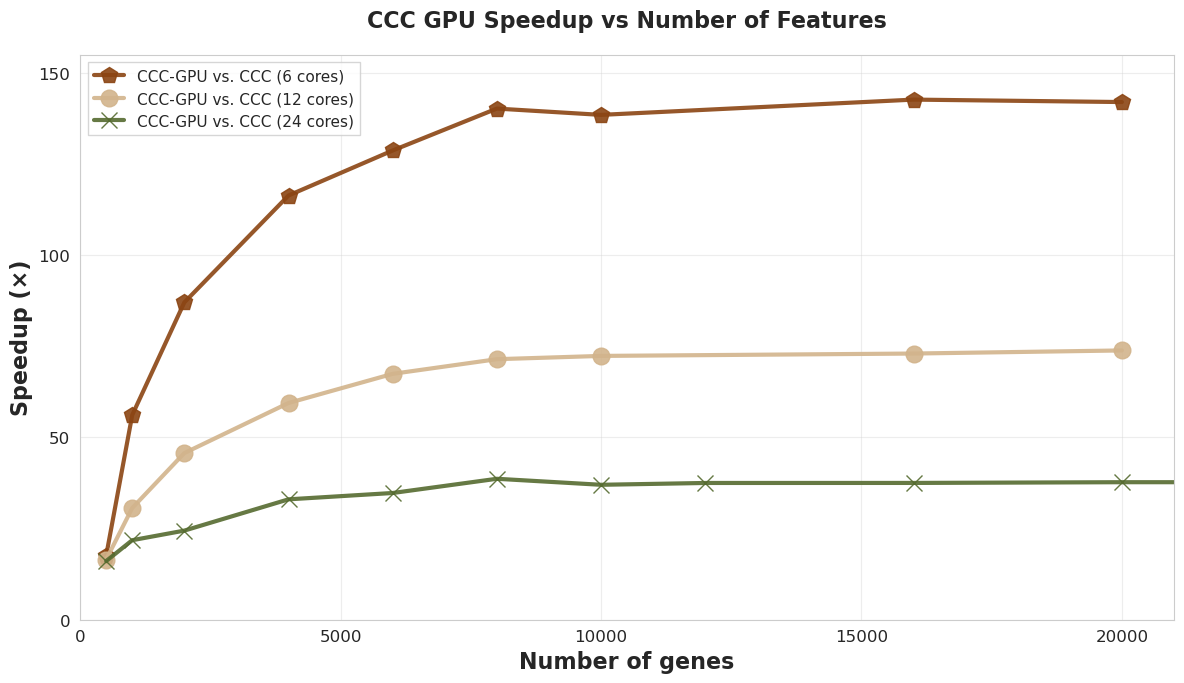

In [100]:
# Set style for publication-quality plots
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))

# Define colors and markers matching the original figure
colors = {
    6: '#8B4513',    # Dark red/brown (saddle brown)
    12: '#D2B48C',   # Tan/beige
    24: '#556B2F'    # Dark olive green
}

markers = {
    6: 'p',   # Pentagon
    12: 'o',  # Circle
    24: 'x'   # X marker
}

# Plot data for each core count
for cores in sorted(df['cores'].unique()):
    df_cores = df[df['cores'] == cores].sort_values('features')
    
    ax.plot(df_cores['features'], df_cores['speedup'], 
            marker=markers.get(cores, 'o'), 
            markersize=12,
            linewidth=3,
            color=colors.get(cores, None),
            label=f'CCC-GPU vs. CCC ({cores} cores)',
            alpha=0.9)

# Formatting
ax.set_xlabel('Number of genes', fontweight='bold', fontsize=16)
ax.set_ylabel('Speedup (×)', fontweight='bold', fontsize=16)
ax.set_title('CCC GPU Speedup vs Number of Features', fontweight='bold', pad=20)

# Set x-axis to linear scale with specific ticks
ax.set_xlim(0, 21000)
ax.set_xticks([0, 5000, 10000, 15000, 20000])

# Set y-axis with specific ticks
ax.set_ylim(0, 155)
ax.set_yticks([0, 50, 100, 150])

# Add grid with light gray color
ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8, color='lightgray')

# Add legend
ax.legend(loc='upper left', frameon=True, fancybox=False, shadow=False, fontsize=11)

# Adjust layout
plt.tight_layout()

# Save figure if SAVE_OUTPUTS is True
if SAVE_OUTPUTS:
    notebook_dir = os.path.dirname(os.path.abspath('speedup_analysis.ipynb'))
    output_file = os.path.join(notebook_dir, 'speedup_chart.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Chart saved to: {output_file}")

plt.show()

## Additional Analysis

In [101]:
# Show speedup table
print("\nSpeedup Summary Table:")
pivot_table = df.pivot_table(values='speedup', index='features', columns='cores', aggfunc='mean')
print(pivot_table.round(2))


Speedup Summary Table:
cores         6      12     24
features                      
500        17.60  16.52  16.10
1000       56.17  30.65  21.82
2000       87.06  45.72  24.45
4000      116.39  59.46  33.03
6000      128.74  67.46  34.77
8000      140.24  71.48  38.67
10000     138.51  72.38  37.02
12000        NaN    NaN  37.52
16000     142.70  73.03  37.53
20000     142.03  73.88  37.73
50000        NaN    NaN  37.70
56200        NaN    NaN  39.45


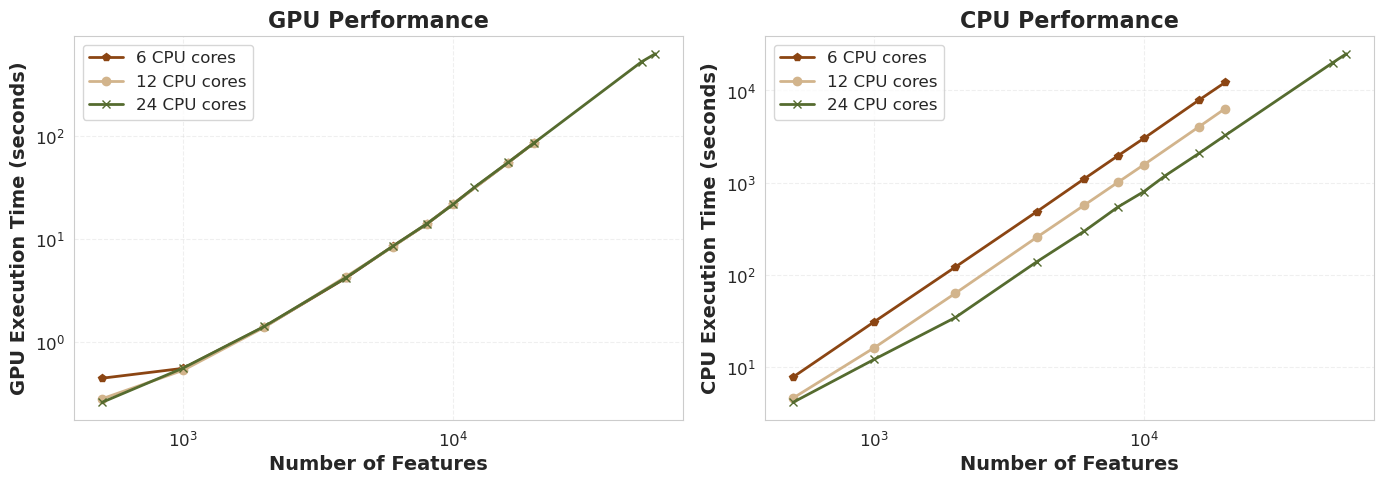

In [102]:
# Show execution time comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# GPU time
for cores in sorted(df['cores'].unique()):
    df_cores = df[df['cores'] == cores].sort_values('features')
    ax1.plot(df_cores['features'], df_cores['gpu_time'], 
             marker=markers.get(cores, 'o'), 
             linewidth=2,
             color=colors.get(cores, None),
             label=f'{cores} CPU cores')

ax1.set_xlabel('Number of Features', fontweight='bold')
ax1.set_ylabel('GPU Execution Time (seconds)', fontweight='bold')
ax1.set_title('GPU Performance', fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend()

# CPU time
for cores in sorted(df['cores'].unique()):
    df_cores = df[df['cores'] == cores].sort_values('features')
    ax2.plot(df_cores['features'], df_cores['cpu_time'], 
             marker=markers.get(cores, 'o'), 
             linewidth=2,
             color=colors.get(cores, None),
             label=f'{cores} CPU cores')

ax2.set_xlabel('Number of Features', fontweight='bold')
ax2.set_ylabel('CPU Execution Time (seconds)', fontweight='bold')
ax2.set_title('CPU Performance', fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend()

plt.tight_layout()

# Save figure if SAVE_OUTPUTS is True
if SAVE_OUTPUTS:
    notebook_dir = os.path.dirname(os.path.abspath('speedup_analysis.ipynb'))
    output_file = os.path.join(notebook_dir, 'execution_time_comparison.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Execution time comparison saved to: {output_file}")

plt.show()

In [103]:
# Export data to CSV for further analysis
if SAVE_OUTPUTS:
    notebook_dir = os.path.dirname(os.path.abspath('speedup_analysis.ipynb'))
    output_csv = os.path.join(notebook_dir, 'benchmark_results.csv')
    df.to_csv(output_csv, index=False)
    print(f"Data exported to: {output_csv}")
else:
    print("CSV export skipped (set SAVE_OUTPUTS = True to enable)")

CSV export skipped (set SAVE_OUTPUTS = True to enable)
